# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

## inits

In [1]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\stim_dataset_1.h5'
model_name = r'D:\github\fish-tracking\train\models\stim_model.h5'
validation_split = .1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time
import h5py as h5
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(devices[0], True)

data_generator = DataGenerator(dataset, zeros_to_nan=True)

%load_ext autoreload
%autoreload 2

## view sample frame

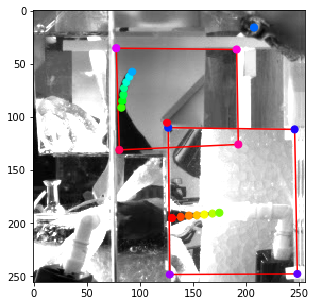

-1


In [4]:
frame_num = np.random.choice(len(data_generator))

image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)

## set up image augmentation

In [5]:
# settings
rotation = (-20, 20)
brightness = (-50, 50)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )

sometimes.append(iaa.AdditiveGaussianNoise(loc=0,
                                           scale=(0.0, 0.05*255))
                )

sometimes.append(iaa.Add(brightness))

augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)



## show augmentation example

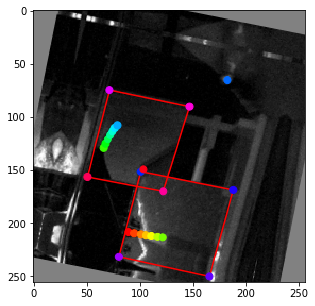

In [6]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [7]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=validation_split, 
                                    use_graph=True,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 57,
 'n_validation': 6,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 52,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset_1.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 63,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (24, 2)}

# check `TrainingGenerator` output

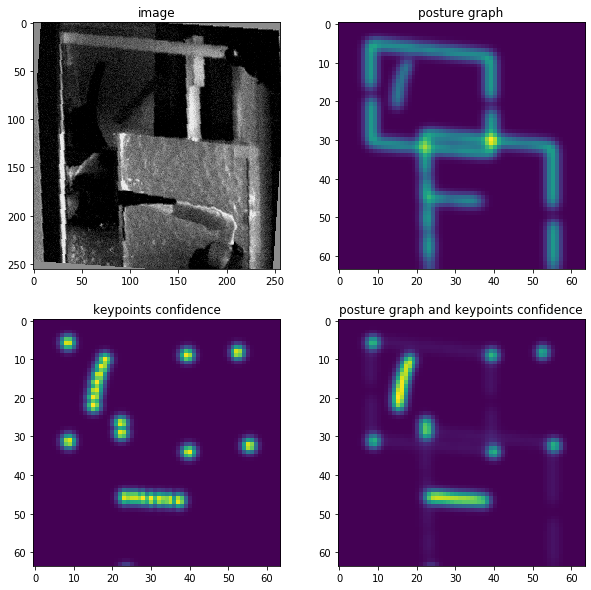

In [8]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# define a model

In [9]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 57,
 'n_validation': 6,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 52,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset_1.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 63,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (24, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [10]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:256], batch_size=100)  # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=32, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 32s 3ms/sample
313.95991022535156


# define training callbacks

In [11]:
logger = Logger(validation_batch_size=4,
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [logger, early_stop, reduce_lr, model_checkpoint]
# if validation_split>0:
#     callbacks.append(logger)  # todo: figure out why logger only works with validation_split>0
# callbacks = [early_stop, reduce_lr, model_checkpoint, logger]


# train

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/400
2/3 [===================>..........] - ETA: 3s - loss: 319.6339 - output_0_loss: 106.5437 - output_1_loss: 107.0764 - output_2_loss: 106.0137 evaluation_metrics: 
euclidean - mean: 3067.64 (0%:  2.96, 5%: 17.72, 25%: 82.57, 50%: 119.01, 75%: 168.54, 95%: 240.26, 100%: 141560.40) 
confidence - mean:  0.01 (0%: -0.00, 5%:  0.00, 25%:  0.00, 50%:  0.01, 75%:  0.01, 95%:  0.01, 100%:  0.01) 


Epoch 00001: val_loss improved from inf to 333.23853, saving model to D:\github\fish-tracking\train\models\stim_model.h5
3/3 [==============================] - 10s 3s/step - loss: 320.8386 - output_0_loss: 107.4539 - output_1_loss: 107.4506 - output_2_loss: 105.9341 - val_loss: 333.2385 - val_output_0_loss: 113.1826 - val_output_1_loss: 111.4358 - val_output_2_loss: 108.6202
Epoch 2/400
2/3 [===================>..........] - ETA: 1s - loss: 298.6032 - output_0_loss: 102.3002 - output_1_loss: 99.8124 - output_2_loss: 96.4906evaluation_metrics: 
euclidean - mean: 3033.74 (0%:  0.82, 5%:  3.

Epoch 12/400
2/3 [===================>..........] - ETA: 1s - loss: 172.3259 - output_0_loss: 72.4209 - output_1_loss: 50.6298 - output_2_loss: 49.2752evaluation_metrics: 
euclidean - mean: 1546.32 (0%:  0.71, 5%:  2.81, 25%: 10.52, 50%: 73.35, 75%: 120.51, 95%: 167.12, 100%: 141657.34) 
confidence - mean:  0.05 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.03, 75%:  0.08, 95%:  0.12, 100%:  0.15) 


Epoch 00012: val_loss did not improve from 224.13611
3/3 [==============================] - 6s 2s/step - loss: 174.8991 - output_0_loss: 73.5685 - output_1_loss: 51.3588 - output_2_loss: 49.9718 - val_loss: 270.8547 - val_output_0_loss: 95.8203 - val_output_1_loss: 87.0164 - val_output_2_loss: 88.0179
Epoch 13/400
2/3 [===================>..........] - ETA: 1s - loss: 170.7323 - output_0_loss: 72.8166 - output_1_loss: 49.6310 - output_2_loss: 48.2848evaluation_metrics: 
euclidean - mean: 1541.25 (0%:  0.97, 5%:  3.03, 25%: 13.97, 50%: 66.35, 75%: 117.77, 95%: 170.87, 100%: 141546.83) 
confide

Epoch 24/400
2/3 [===================>..........] - ETA: 1s - loss: 128.7406 - output_0_loss: 51.0447 - output_1_loss: 40.1758 - output_2_loss: 37.5201evaluation_metrics: 
euclidean - mean: 4481.83 (0%:  0.56, 5%:  1.76, 25%:  7.78, 50%: 29.45, 75%: 109.61, 95%: 162.83, 100%: 141663.98) 
confidence - mean:  0.08 (0%:  0.01, 5%:  0.01, 25%:  0.03, 50%:  0.06, 75%:  0.12, 95%:  0.19, 100%:  0.25) 


Epoch 00024: val_loss did not improve from 224.13611
3/3 [==============================] - 6s 2s/step - loss: 125.9971 - output_0_loss: 50.1259 - output_1_loss: 39.3203 - output_2_loss: 36.5508 - val_loss: 266.4828 - val_output_0_loss: 96.1191 - val_output_1_loss: 85.5086 - val_output_2_loss: 84.8551
Epoch 25/400
2/3 [===================>..........] - ETA: 1s - loss: 129.8261 - output_0_loss: 51.3094 - output_1_loss: 40.6654 - output_2_loss: 37.8513evaluation_metrics: 
euclidean - mean: 3018.80 (0%:  0.11, 5%:  1.86, 25%: 11.54, 50%: 79.89, 75%: 119.74, 95%: 164.45, 100%: 141655.73) 
confide

Epoch 36/400
2/3 [===================>..........] - ETA: 1s - loss: 100.9025 - output_0_loss: 41.8360 - output_1_loss: 32.7904 - output_2_loss: 26.2762evaluation_metrics: 
euclidean - mean: 2999.76 (0%:  0.41, 5%:  1.04, 25%:  3.76, 50%: 20.61, 75%: 94.25, 95%: 202.49, 100%: 141648.74) 
confidence - mean:  0.07 (0%:  0.01, 5%:  0.01, 25%:  0.03, 50%:  0.05, 75%:  0.09, 95%:  0.17, 100%:  0.23) 


Epoch 00036: val_loss did not improve from 224.13611
3/3 [==============================] - 6s 2s/step - loss: 103.3804 - output_0_loss: 42.9073 - output_1_loss: 33.4225 - output_2_loss: 27.0505 - val_loss: 268.0420 - val_output_0_loss: 96.0864 - val_output_1_loss: 87.3613 - val_output_2_loss: 84.5943
Epoch 37/400
2/3 [===================>..........] - ETA: 1s - loss: 105.7357 - output_0_loss: 44.1402 - output_1_loss: 34.0948 - output_2_loss: 27.5007evaluation_metrics: 
euclidean - mean: 4474.95 (0%:  0.47, 5%:  1.02, 25%:  4.16, 50%: 15.16, 75%: 98.74, 95%: 202.34, 100%: 141648.58) 
confidenc

Epoch 48/400
2/3 [===================>..........] - ETA: 1s - loss: 98.1939 - output_0_loss: 42.1715 - output_1_loss: 32.0154 - output_2_loss: 24.0070evaluation_metrics: 
euclidean - mean: 4454.10 (0%:  0.79, 5%:  1.16, 25%:  2.27, 50%:  5.50, 75%: 16.99, 95%: 204.23, 100%: 141646.99) 
confidence - mean:  0.14 (0%:  0.02, 5%:  0.02, 25%:  0.08, 50%:  0.13, 75%:  0.20, 95%:  0.28, 100%:  0.37) 


Epoch 00048: val_loss improved from 224.13611 to 215.35297, saving model to D:\github\fish-tracking\train\models\stim_model.h5
3/3 [==============================] - 6s 2s/step - loss: 97.6674 - output_0_loss: 41.9079 - output_1_loss: 31.8868 - output_2_loss: 23.8726 - val_loss: 215.3530 - val_output_0_loss: 84.1862 - val_output_1_loss: 67.9484 - val_output_2_loss: 63.2183
Epoch 49/400
2/3 [===================>..........] - ETA: 1s - loss: 97.1281 - output_0_loss: 41.3057 - output_1_loss: 31.8250 - output_2_loss: 23.9974 evaluation_metrics: 
euclidean - mean: 2992.55 (0%:  0.43, 5%:  1.02, 25%:

Epoch 60/400
2/3 [===================>..........] - ETA: 1s - loss: 92.0091 - output_0_loss: 40.4936 - output_1_loss: 30.1856 - output_2_loss: 21.3299evaluation_metrics: 
euclidean - mean: 4451.26 (0%:  0.56, 5%:  1.31, 25%:  2.62, 50%:  5.41, 75%: 14.01, 95%: 227.74, 100%: 141539.62) 
confidence - mean:  0.17 (0%:  0.02, 5%:  0.03, 25%:  0.11, 50%:  0.19, 75%:  0.24, 95%:  0.31, 100%:  0.37) 


Epoch 00060: val_loss did not improve from 215.35297
3/3 [==============================] - 6s 2s/step - loss: 92.3789 - output_0_loss: 40.8929 - output_1_loss: 30.2088 - output_2_loss: 21.2772 - val_loss: 221.7623 - val_output_0_loss: 87.8580 - val_output_1_loss: 69.8279 - val_output_2_loss: 64.0764
Epoch 61/400
2/3 [===================>..........] - ETA: 1s - loss: 89.1955 - output_0_loss: 39.8806 - output_1_loss: 29.1759 - output_2_loss: 20.1390evaluation_metrics: 
euclidean - mean: 1507.12 (0%:  0.46, 5%:  0.87, 25%:  1.93, 50%:  4.30, 75%: 12.95, 95%: 170.19, 100%: 141539.67) 
confidence -

2/3 [===================>..........] - ETA: 1s - loss: 83.2381 - output_0_loss: 38.3077 - output_1_loss: 27.1508 - output_2_loss: 17.7797evaluation_metrics: 
euclidean - mean: 4450.60 (0%:  0.57, 5%:  0.90, 25%:  1.84, 50%:  3.64, 75%:  9.35, 95%: 231.14, 100%: 141550.67) 
confidence - mean:  0.26 (0%:  0.02, 5%:  0.03, 25%:  0.15, 50%:  0.28, 75%:  0.36, 95%:  0.45, 100%:  0.57) 


Epoch 00071: val_loss did not improve from 177.33823
3/3 [==============================] - 6s 2s/step - loss: 83.2343 - output_0_loss: 38.2366 - output_1_loss: 27.1596 - output_2_loss: 17.8381 - val_loss: 201.6897 - val_output_0_loss: 83.2060 - val_output_1_loss: 63.2862 - val_output_2_loss: 55.1975
Epoch 72/400
2/3 [===================>..........] - ETA: 1s - loss: 82.1598 - output_0_loss: 37.1821 - output_1_loss: 27.0327 - output_2_loss: 17.9450evaluation_metrics: 
euclidean - mean: 2978.54 (0%:  0.33, 5%:  0.99, 25%:  2.19, 50%:  4.03, 75%: 12.66, 95%: 163.89, 100%: 141550.95) 
confidence - mean:  0.22 

Epoch 83/400
2/3 [===================>..........] - ETA: 1s - loss: 77.2253 - output_0_loss: 36.4129 - output_1_loss: 25.2832 - output_2_loss: 15.5292evaluation_metrics: 
euclidean - mean: 4445.01 (0%:  0.04, 5%:  0.47, 25%:  2.04, 50%:  3.44, 75%:  7.67, 95%: 154.06, 100%: 141551.32) 
confidence - mean:  0.31 (0%:  0.04, 5%:  0.05, 25%:  0.21, 50%:  0.34, 75%:  0.42, 95%:  0.49, 100%:  0.52) 


Epoch 00083: val_loss improved from 171.49506 to 150.59854, saving model to D:\github\fish-tracking\train\models\stim_model.h5
3/3 [==============================] - 6s 2s/step - loss: 77.4331 - output_0_loss: 36.4259 - output_1_loss: 25.2816 - output_2_loss: 15.7256 - val_loss: 150.5985 - val_output_0_loss: 66.4320 - val_output_1_loss: 47.0425 - val_output_2_loss: 37.1241
Epoch 84/400
2/3 [===================>..........] - ETA: 1s - loss: 77.1816 - output_0_loss: 36.2860 - output_1_loss: 25.0893 - output_2_loss: 15.8062evaluation_metrics: 
euclidean - mean: 2971.16 (0%:  0.28, 5%:  0.72, 25%: 

Epoch 95/400
2/3 [===================>..........] - ETA: 1s - loss: 73.9680 - output_0_loss: 35.8860 - output_1_loss: 23.7061 - output_2_loss: 14.3759evaluation_metrics: 
euclidean - mean: 4443.18 (0%:  0.26, 5%:  0.57, 25%:  1.75, 50%:  3.34, 75%:  8.13, 95%: 147.39, 100%: 141550.93) 
confidence - mean:  0.35 (0%:  0.05, 5%:  0.06, 25%:  0.24, 50%:  0.40, 75%:  0.46, 95%:  0.56, 100%:  0.60) 


Epoch 00095: val_loss did not improve from 150.59854
3/3 [==============================] - 6s 2s/step - loss: 72.4998 - output_0_loss: 35.3241 - output_1_loss: 23.3374 - output_2_loss: 13.8382 - val_loss: 163.9625 - val_output_0_loss: 72.0689 - val_output_1_loss: 51.4570 - val_output_2_loss: 40.4366
Epoch 96/400
2/3 [===================>..........] - ETA: 1s - loss: 71.3816 - output_0_loss: 35.0241 - output_1_loss: 23.0367 - output_2_loss: 13.3208evaluation_metrics: 
euclidean - mean: 2967.86 (0%:  0.33, 5%:  0.54, 25%:  1.52, 50%:  2.76, 75%:  8.48, 95%: 136.38, 100%: 141551.58) 
confidence -

Epoch 107/400
2/3 [===================>..........] - ETA: 1s - loss: 70.7537 - output_0_loss: 34.7062 - output_1_loss: 22.9201 - output_2_loss: 13.1274evaluation_metrics: 
euclidean - mean: 2964.41 (0%:  0.27, 5%:  0.60, 25%:  1.32, 50%:  2.65, 75%:  6.10, 95%: 135.10, 100%: 141549.54) 
confidence - mean:  0.38 (0%:  0.04, 5%:  0.08, 25%:  0.25, 50%:  0.44, 75%:  0.53, 95%:  0.63, 100%:  0.69) 


Epoch 00107: val_loss did not improve from 131.98578
3/3 [==============================] - 6s 2s/step - loss: 71.5766 - output_0_loss: 35.0272 - output_1_loss: 22.9563 - output_2_loss: 13.5930 - val_loss: 134.4304 - val_output_0_loss: 62.7419 - val_output_1_loss: 42.0974 - val_output_2_loss: 29.5910
Epoch 108/400
2/3 [===================>..........] - ETA: 1s - loss: 71.6957 - output_0_loss: 35.1701 - output_1_loss: 22.9716 - output_2_loss: 13.5540evaluation_metrics: 
euclidean - mean: 4439.92 (0%:  0.06, 5%:  0.34, 25%:  1.24, 50%:  2.38, 75%:  5.64, 95%: 136.57, 100%: 141563.18) 
confidence

3/3 [==============================] - 6s 2s/step - loss: 64.2205 - output_0_loss: 32.9267 - output_1_loss: 20.2628 - output_2_loss: 11.0310 - val_loss: 102.4097 - val_output_0_loss: 50.6293 - val_output_1_loss: 32.1111 - val_output_2_loss: 19.6693
Epoch 119/400
2/3 [===================>..........] - ETA: 1s - loss: 70.0010 - output_0_loss: 34.8421 - output_1_loss: 22.1064 - output_2_loss: 13.0526evaluation_metrics: 
euclidean - mean: 2961.88 (0%:  0.19, 5%:  0.39, 25%:  1.05, 50%:  1.88, 75%:  4.75, 95%: 140.05, 100%: 141551.07) 
confidence - mean:  0.43 (0%:  0.05, 5%:  0.11, 25%:  0.33, 50%:  0.47, 75%:  0.55, 95%:  0.68, 100%:  0.73) 


Epoch 00119: val_loss did not improve from 102.40967
3/3 [==============================] - 6s 2s/step - loss: 69.0033 - output_0_loss: 34.4554 - output_1_loss: 21.7235 - output_2_loss: 12.8244 - val_loss: 108.6106 - val_output_0_loss: 52.5106 - val_output_1_loss: 34.4274 - val_output_2_loss: 21.6726
Epoch 120/400
2/3 [===================>..........

2/3 [===================>..........] - ETA: 1s - loss: 60.7239 - output_0_loss: 32.2339 - output_1_loss: 18.5030 - output_2_loss: 9.9870 evaluation_metrics: 
euclidean - mean: 2957.22 (0%:  0.09, 5%:  0.39, 25%:  1.32, 50%:  2.07, 75%:  3.14, 95%: 131.85, 100%: 141550.10) 
confidence - mean:  0.47 (0%:  0.03, 5%:  0.11, 25%:  0.37, 50%:  0.53, 75%:  0.60, 95%:  0.68, 100%:  0.73) 


Epoch 00130: val_loss did not improve from 91.55333
3/3 [==============================] - 6s 2s/step - loss: 61.2510 - output_0_loss: 32.2397 - output_1_loss: 18.7718 - output_2_loss: 10.2395 - val_loss: 109.9568 - val_output_0_loss: 53.3814 - val_output_1_loss: 34.1071 - val_output_2_loss: 22.4684
Epoch 131/400
2/3 [===================>..........] - ETA: 1s - loss: 66.6636 - output_0_loss: 33.9944 - output_1_loss: 20.8502 - output_2_loss: 11.8190evaluation_metrics: 
euclidean - mean: 2956.28 (0%:  0.06, 5%:  0.42, 25%:  1.24, 50%:  1.79, 75%:  3.18, 95%: 132.37, 100%: 141542.38) 
confidence - mean:  0.48 

Epoch 142/400
2/3 [===================>..........] - ETA: 1s - loss: 62.4510 - output_0_loss: 32.7723 - output_1_loss: 19.1948 - output_2_loss: 10.4839evaluation_metrics: 
euclidean - mean: 1479.86 (0%:  0.13, 5%:  0.32, 25%:  1.04, 50%:  1.53, 75%:  3.42, 95%: 12.08, 100%: 141462.03) 
confidence - mean:  0.53 (0%:  0.04, 5%:  0.13, 25%:  0.43, 50%:  0.57, 75%:  0.69, 95%:  0.79, 100%:  0.86) 


Epoch 00142: val_loss did not improve from 87.87772
3/3 [==============================] - 6s 2s/step - loss: 64.3570 - output_0_loss: 33.3986 - output_1_loss: 19.8165 - output_2_loss: 11.1419 - val_loss: 101.8173 - val_output_0_loss: 50.8927 - val_output_1_loss: 31.7661 - val_output_2_loss: 19.1585
Epoch 143/400
2/3 [===================>..........] - ETA: 1s - loss: 66.8340 - output_0_loss: 33.4112 - output_1_loss: 20.7103 - output_2_loss: 12.7125evaluation_metrics: 
euclidean - mean: 1480.59 (0%:  0.14, 5%:  0.41, 25%:  0.99, 50%:  1.52, 75%:  2.46, 95%: 15.61, 100%: 141526.94) 
confidence - 

Epoch 154/400
2/3 [===================>..........] - ETA: 1s - loss: 59.4578 - output_0_loss: 31.6918 - output_1_loss: 18.0347 - output_2_loss: 9.7312evaluation_metrics: 
euclidean - mean: 1477.59 (0%:  0.16, 5%:  0.33, 25%:  0.96, 50%:  1.49, 75%:  2.35, 95%:  9.40, 100%: 141526.55) 
confidence - mean:  0.60 (0%:  0.03, 5%:  0.17, 25%:  0.51, 50%:  0.66, 75%:  0.75, 95%:  0.87, 100%:  0.92) 


Epoch 00154: val_loss did not improve from 84.55250
3/3 [==============================] - 6s 2s/step - loss: 61.5675 - output_0_loss: 32.5998 - output_1_loss: 18.7532 - output_2_loss: 10.2144 - val_loss: 87.4966 - val_output_0_loss: 45.3966 - val_output_1_loss: 26.5601 - val_output_2_loss: 15.5399
Epoch 155/400
2/3 [===================>..........] - ETA: 1s - loss: 58.3672 - output_0_loss: 31.6000 - output_1_loss: 17.4269 - output_2_loss: 9.3402evaluation_metrics: 
euclidean - mean: 2953.43 (0%:  0.14, 5%:  0.46, 25%:  0.86, 50%:  1.55, 75%:  2.38, 95%: 12.84, 100%: 141541.59) 
confidence - mea

3/3 [==============================] - 6s 2s/step - loss: 58.1268 - output_0_loss: 31.1225 - output_1_loss: 17.5458 - output_2_loss: 9.4585 - val_loss: 70.6038 - val_output_0_loss: 37.9138 - val_output_1_loss: 21.2582 - val_output_2_loss: 11.4318
Epoch 166/400
2/3 [===================>..........] - ETA: 1s - loss: 56.9481 - output_0_loss: 31.0280 - output_1_loss: 16.9419 - output_2_loss: 8.9782evaluation_metrics: 
euclidean - mean: 1478.87 (0%:  0.12, 5%:  0.24, 25%:  0.86, 50%:  1.42, 75%:  2.21, 95%:  9.90, 100%: 141527.99) 
confidence - mean:  0.60 (0%:  0.03, 5%:  0.19, 25%:  0.48, 50%:  0.65, 75%:  0.74, 95%:  0.82, 100%:  0.92) 


Epoch 00166: val_loss did not improve from 70.60382
3/3 [==============================] - 6s 2s/step - loss: 58.1105 - output_0_loss: 31.4673 - output_1_loss: 17.3813 - output_2_loss: 9.2620 - val_loss: 87.9187 - val_output_0_loss: 45.6097 - val_output_1_loss: 27.2258 - val_output_2_loss: 15.0832
Epoch 167/400
2/3 [===================>..........] - ETA

2/3 [===================>..........] - ETA: 1s - loss: 53.3325 - output_0_loss: 29.9618 - output_1_loss: 15.6302 - output_2_loss: 7.7405evaluation_metrics: 
euclidean - mean: 1477.55 (0%:  0.04, 5%:  0.33, 25%:  0.85, 50%:  1.39, 75%:  2.14, 95%:  7.73, 100%: 141541.20) 
confidence - mean:  0.59 (0%:  0.09, 5%:  0.20, 25%:  0.54, 50%:  0.65, 75%:  0.71, 95%:  0.81, 100%:  0.89) 


Epoch 00177: val_loss did not improve from 63.74870
3/3 [==============================] - 6s 2s/step - loss: 54.5816 - output_0_loss: 30.2552 - output_1_loss: 16.0948 - output_2_loss: 8.2317 - val_loss: 69.8295 - val_output_0_loss: 36.7580 - val_output_1_loss: 20.9640 - val_output_2_loss: 12.1075
Epoch 178/400
2/3 [===================>..........] - ETA: 1s - loss: 54.2806 - output_0_loss: 30.0302 - output_1_loss: 15.8571 - output_2_loss: 8.3933evaluation_metrics: 
euclidean - mean: 4425.93 (0%:  0.06, 5%:  0.24, 25%:  0.86, 50%:  1.36, 75%:  1.97, 95%:  7.50, 100%: 141658.23) 
confidence - mean:  0.67 (0%:  

Epoch 189/400
2/3 [===================>..........] - ETA: 1s - loss: 55.4806 - output_0_loss: 30.6298 - output_1_loss: 16.2546 - output_2_loss: 8.5963evaluation_metrics: 
euclidean - mean: 4427.23 (0%:  0.11, 5%:  0.30, 25%:  0.84, 50%:  1.39, 75%:  2.24, 95%: 10.50, 100%: 141746.88) 
confidence - mean:  0.68 (0%:  0.04, 5%:  0.22, 25%:  0.60, 50%:  0.74, 75%:  0.82, 95%:  0.91, 100%:  0.97) 


Epoch 00189: val_loss did not improve from 62.90460
3/3 [==============================] - 6s 2s/step - loss: 55.8938 - output_0_loss: 30.4922 - output_1_loss: 16.4062 - output_2_loss: 8.9954 - val_loss: 68.2929 - val_output_0_loss: 36.2352 - val_output_1_loss: 20.2673 - val_output_2_loss: 11.7904
Epoch 190/400
2/3 [===================>..........] - ETA: 1s - loss: 53.6739 - output_0_loss: 29.7199 - output_1_loss: 15.5319 - output_2_loss: 8.4221evaluation_metrics: 
euclidean - mean: 1479.76 (0%:  0.14, 5%:  0.35, 25%:  0.75, 50%:  1.30, 75%:  2.20, 95%: 10.50, 100%: 141527.82) 
confidence - mean

Epoch 201/400
2/3 [===================>..........] - ETA: 1s - loss: 48.6789 - output_0_loss: 27.8315 - output_1_loss: 13.8820 - output_2_loss: 6.9654evaluation_metrics: 
euclidean - mean: 4426.73 (0%:  0.06, 5%:  0.27, 25%:  0.64, 50%:  1.15, 75%:  1.97, 95%:  6.60, 100%: 141747.25) 
confidence - mean:  0.67 (0%:  0.05, 5%:  0.18, 25%:  0.64, 50%:  0.73, 75%:  0.81, 95%:  0.88, 100%:  0.94) 


Epoch 00201: val_loss did not improve from 61.43523
3/3 [==============================] - 6s 2s/step - loss: 49.0310 - output_0_loss: 27.9033 - output_1_loss: 14.0398 - output_2_loss: 7.0879 - val_loss: 78.5380 - val_output_0_loss: 41.5794 - val_output_1_loss: 23.7379 - val_output_2_loss: 13.2207
Epoch 202/400
2/3 [===================>..........] - ETA: 1s - loss: 49.2116 - output_0_loss: 28.2628 - output_1_loss: 13.9648 - output_2_loss: 6.9840evaluation_metrics: 
euclidean - mean: 2950.05 (0%:  0.19, 5%:  0.34, 25%:  0.69, 50%:  1.13, 75%:  1.70, 95%:  4.06, 100%: 141540.80) 
confidence - mean

Epoch 213/400
2/3 [===================>..........] - ETA: 1s - loss: 48.9677 - output_0_loss: 28.2120 - output_1_loss: 13.5880 - output_2_loss: 7.1678evaluation_metrics: 
euclidean - mean: 4427.34 (0%:  0.10, 5%:  0.29, 25%:  0.74, 50%:  1.25, 75%:  2.05, 95%:  7.60, 100%: 141747.65) 
confidence - mean:  0.72 (0%:  0.04, 5%:  0.29, 25%:  0.66, 50%:  0.77, 75%:  0.84, 95%:  0.93, 100%:  1.00) 


Epoch 00213: val_loss did not improve from 59.19177
3/3 [==============================] - 6s 2s/step - loss: 48.6808 - output_0_loss: 28.0950 - output_1_loss: 13.6057 - output_2_loss: 6.9801 - val_loss: 68.5833 - val_output_0_loss: 38.9616 - val_output_1_loss: 19.7733 - val_output_2_loss: 9.8484
Epoch 214/400
2/3 [===================>..........] - ETA: 1s - loss: 48.9001 - output_0_loss: 27.9677 - output_1_loss: 13.8270 - output_2_loss: 7.1054evaluation_metrics: 
euclidean - mean: 2950.28 (0%:  0.07, 5%:  0.27, 25%:  0.59, 50%:  0.99, 75%:  1.59, 95%:  4.82, 100%: 141557.77) 
confidence - mean:

Epoch 225/400
2/3 [===================>..........] - ETA: 1s - loss: 49.6705 - output_0_loss: 28.2755 - output_1_loss: 14.0056 - output_2_loss: 7.3894evaluation_metrics: 
euclidean - mean: 2950.41 (0%:  0.07, 5%:  0.24, 25%:  0.56, 50%:  1.01, 75%:  1.66, 95%:  5.48, 100%: 141565.67) 
confidence - mean:  0.70 (0%:  0.05, 5%:  0.35, 25%:  0.59, 50%:  0.74, 75%:  0.84, 95%:  0.90, 100%:  0.98) 


Epoch 00225: val_loss did not improve from 51.36731
3/3 [==============================] - 6s 2s/step - loss: 48.5342 - output_0_loss: 27.7433 - output_1_loss: 13.6365 - output_2_loss: 7.1544 - val_loss: 55.5148 - val_output_0_loss: 31.6238 - val_output_1_loss: 15.8099 - val_output_2_loss: 8.0811
Epoch 226/400
2/3 [===================>..........] - ETA: 1s - loss: 47.1111 - output_0_loss: 27.2324 - output_1_loss: 13.2305 - output_2_loss: 6.6482evaluation_metrics: 
euclidean - mean: 4426.86 (0%:  0.12, 5%:  0.23, 25%:  0.67, 50%:  1.26, 75%:  1.98, 95%:  7.89, 100%: 141747.59) 
confidence - mean:

Epoch 237/400
2/3 [===================>..........] - ETA: 1s - loss: 43.4894 - output_0_loss: 26.3648 - output_1_loss: 11.5171 - output_2_loss: 5.6075evaluation_metrics: 
euclidean - mean: 2952.44 (0%:  0.13, 5%:  0.28, 25%:  0.70, 50%:  1.20, 75%:  1.86, 95%:  5.72, 100%: 141747.48) 
confidence - mean:  0.73 (0%:  0.06, 5%:  0.42, 25%:  0.68, 50%:  0.77, 75%:  0.84, 95%:  0.91, 100%:  0.95) 


Epoch 00237: val_loss did not improve from 48.64903
3/3 [==============================] - 6s 2s/step - loss: 43.6036 - output_0_loss: 26.4200 - output_1_loss: 11.6136 - output_2_loss: 5.5700 - val_loss: 63.0081 - val_output_0_loss: 35.0143 - val_output_1_loss: 17.9751 - val_output_2_loss: 10.0188
Epoch 238/400
2/3 [===================>..........] - ETA: 1s - loss: 45.8095 - output_0_loss: 26.9622 - output_1_loss: 12.4498 - output_2_loss: 6.3974evaluation_metrics: 
euclidean - mean: 2952.65 (0%:  0.13, 5%:  0.24, 25%:  0.64, 50%:  1.16, 75%:  2.08, 95%:  7.35, 100%: 141747.87) 
confidence - mean

Epoch 249/400
2/3 [===================>..........] - ETA: 1s - loss: 44.2744 - output_0_loss: 26.2313 - output_1_loss: 11.8547 - output_2_loss: 6.1884evaluation_metrics: 
euclidean - mean: 2951.90 (0%:  0.08, 5%:  0.29, 25%:  0.68, 50%:  1.19, 75%:  2.41, 95%:  7.50, 100%: 141659.73) 
confidence - mean:  0.72 (0%:  0.05, 5%:  0.35, 25%:  0.64, 50%:  0.78, 75%:  0.84, 95%:  0.91, 100%:  0.96) 


Epoch 00249: val_loss did not improve from 48.64903
3/3 [==============================] - 6s 2s/step - loss: 44.8043 - output_0_loss: 26.4833 - output_1_loss: 12.0024 - output_2_loss: 6.3187 - val_loss: 51.4235 - val_output_0_loss: 29.2192 - val_output_1_loss: 14.2423 - val_output_2_loss: 7.9620
Epoch 250/400
2/3 [===================>..........] - ETA: 1s - loss: 44.8013 - output_0_loss: 26.6644 - output_1_loss: 11.9386 - output_2_loss: 6.1983evaluation_metrics: 
euclidean - mean: 2950.58 (0%:  0.07, 5%:  0.23, 25%:  0.71, 50%:  1.01, 75%:  1.72, 95%:  7.42, 100%: 141565.53) 
confidence - mean:

Epoch 261/400
2/3 [===================>..........] - ETA: 1s - loss: 41.0166 - output_0_loss: 25.3617 - output_1_loss: 10.5672 - output_2_loss: 5.0878evaluation_metrics: 
euclidean - mean: 4424.34 (0%:  0.06, 5%:  0.22, 25%:  0.59, 50%:  0.95, 75%:  2.02, 95%:  6.07, 100%: 141537.12) 
confidence - mean:  0.77 (0%:  0.05, 5%:  0.35, 25%:  0.73, 50%:  0.84, 75%:  0.90, 95%:  0.96, 100%:  1.08) 


Epoch 00261: val_loss did not improve from 42.97414
3/3 [==============================] - 6s 2s/step - loss: 42.9492 - output_0_loss: 26.1872 - output_1_loss: 11.1825 - output_2_loss: 5.5795 - val_loss: 53.8213 - val_output_0_loss: 31.7917 - val_output_1_loss: 14.7237 - val_output_2_loss: 7.3059
Epoch 262/400
2/3 [===================>..........] - ETA: 1s - loss: 42.1955 - output_0_loss: 25.6026 - output_1_loss: 10.9043 - output_2_loss: 5.6885evaluation_metrics: 
euclidean - mean: 2950.06 (0%:  0.09, 5%:  0.18, 25%:  0.49, 50%:  0.91, 75%:  1.48, 95%:  7.23, 100%: 141538.11) 
confidence - mean:

Epoch 273/400
2/3 [===================>..........] - ETA: 1s - loss: 41.6581 - output_0_loss: 25.5482 - output_1_loss: 10.6715 - output_2_loss: 5.4384evaluation_metrics: 
euclidean - mean: 2950.19 (0%:  0.09, 5%:  0.15, 25%:  0.55, 50%:  0.94, 75%:  1.56, 95%:  7.57, 100%: 141538.65) 
confidence - mean:  0.77 (0%:  0.05, 5%:  0.40, 25%:  0.72, 50%:  0.81, 75%:  0.88, 95%:  0.94, 100%:  1.06) 


Epoch 00273: val_loss did not improve from 42.82281
3/3 [==============================] - 6s 2s/step - loss: 43.1640 - output_0_loss: 25.9389 - output_1_loss: 11.1570 - output_2_loss: 6.0682 - val_loss: 53.4068 - val_output_0_loss: 31.1075 - val_output_1_loss: 14.3074 - val_output_2_loss: 7.9919
Epoch 274/400
2/3 [===================>..........] - ETA: 1s - loss: 40.3639 - output_0_loss: 24.7357 - output_1_loss: 10.2219 - output_2_loss: 5.4063evaluation_metrics: 
euclidean - mean: 2949.79 (0%:  0.11, 5%:  0.19, 25%:  0.49, 50%:  0.89, 75%:  1.20, 95%:  5.51, 100%: 141539.70) 
confidence - mean:

Epoch 285/400
2/3 [===================>..........] - ETA: 1s - loss: 39.7283 - output_0_loss: 24.4851 - output_1_loss: 9.9870 - output_2_loss: 5.2562evaluation_metrics: 
euclidean - mean: 4426.33 (0%:  0.16, 5%:  0.28, 25%:  0.54, 50%:  0.93, 75%:  1.47, 95%:  4.12, 100%: 141747.36) 
confidence - mean:  0.80 (0%:  0.05, 5%:  0.53, 25%:  0.74, 50%:  0.85, 75%:  0.91, 95%:  0.96, 100%:  1.11) 


Epoch 00285: val_loss did not improve from 41.37984
3/3 [==============================] - 6s 2s/step - loss: 39.5107 - output_0_loss: 24.4486 - output_1_loss: 9.8333 - output_2_loss: 5.2288 - val_loss: 42.3966 - val_output_0_loss: 25.2947 - val_output_1_loss: 11.1011 - val_output_2_loss: 6.0008
Epoch 286/400
2/3 [===================>..........] - ETA: 1s - loss: 43.3757 - output_0_loss: 26.2413 - output_1_loss: 11.1227 - output_2_loss: 6.0117evaluation_metrics: 
euclidean - mean: 2949.89 (0%:  0.11, 5%:  0.21, 25%:  0.48, 50%:  0.94, 75%:  1.55, 95%:  5.00, 100%: 141539.76) 
confidence - mean:  

Epoch 297/400
2/3 [===================>..........] - ETA: 1s - loss: 40.3057 - output_0_loss: 24.8269 - output_1_loss: 9.8980 - output_2_loss: 5.5808 evaluation_metrics: 
euclidean - mean: 2952.00 (0%:  0.12, 5%:  0.30, 25%:  0.56, 50%:  0.91, 75%:  1.68, 95%:  5.23, 100%: 141737.04) 
confidence - mean:  0.81 (0%:  0.06, 5%:  0.59, 25%:  0.76, 50%:  0.83, 75%:  0.90, 95%:  0.97, 100%:  1.05) 


Epoch 00297: val_loss did not improve from 39.48539
3/3 [==============================] - 6s 2s/step - loss: 39.8335 - output_0_loss: 24.4976 - output_1_loss: 9.8331 - output_2_loss: 5.5027 - val_loss: 40.7364 - val_output_0_loss: 25.0755 - val_output_1_loss: 10.1488 - val_output_2_loss: 5.5121
Epoch 298/400
2/3 [===================>..........] - ETA: 1s - loss: 36.2604 - output_0_loss: 23.4894 - output_1_loss: 8.5346 - output_2_loss: 4.2365evaluation_metrics: 
euclidean - mean: 2950.73 (0%:  0.11, 5%:  0.22, 25%:  0.52, 50%:  0.97, 75%:  1.67, 95%:  5.10, 100%: 141593.41) 
confidence - mean:  

Epoch 309/400
2/3 [===================>..........] - ETA: 1s - loss: 37.2564 - output_0_loss: 23.9556 - output_1_loss: 8.8310 - output_2_loss: 4.4699evaluation_metrics: 
euclidean - mean: 4425.57 (0%:  0.04, 5%:  0.21, 25%:  0.43, 50%:  0.97, 75%:  1.60, 95%:  5.50, 100%: 141670.07) 
confidence - mean:  0.81 (0%:  0.03, 5%:  0.59, 25%:  0.76, 50%:  0.85, 75%:  0.90, 95%:  0.97, 100%:  1.01) 


Epoch 00309: val_loss did not improve from 37.39066
3/3 [==============================] - 6s 2s/step - loss: 37.4629 - output_0_loss: 23.8227 - output_1_loss: 8.9251 - output_2_loss: 4.7150 - val_loss: 48.0412 - val_output_0_loss: 29.0438 - val_output_1_loss: 12.0558 - val_output_2_loss: 6.9416
Epoch 310/400
2/3 [===================>..........] - ETA: 1s - loss: 40.4166 - output_0_loss: 24.6904 - output_1_loss: 9.9605 - output_2_loss: 5.7656evaluation_metrics: 
euclidean - mean: 2949.82 (0%:  0.06, 5%:  0.16, 25%:  0.43, 50%:  1.00, 75%:  1.58, 95%:  4.26, 100%: 141537.46) 
confidence - mean:  0

Epoch 321/400
2/3 [===================>..........] - ETA: 2s - loss: 38.5984 - output_0_loss: 23.8441 - output_1_loss: 9.3269 - output_2_loss: 5.4274evaluation_metrics: 
euclidean - mean: 2951.51 (0%:  0.04, 5%:  0.20, 25%:  0.55, 50%:  0.97, 75%:  1.40, 95%:  8.10, 100%: 141640.27) 
confidence - mean:  0.81 (0%:  0.04, 5%:  0.42, 25%:  0.77, 50%:  0.86, 75%:  0.91, 95%:  0.96, 100%:  1.05) 


Epoch 00321: val_loss did not improve from 37.39066
3/3 [==============================] - 6s 2s/step - loss: 38.6117 - output_0_loss: 23.8762 - output_1_loss: 9.3728 - output_2_loss: 5.3627 - val_loss: 49.7518 - val_output_0_loss: 28.2845 - val_output_1_loss: 12.7314 - val_output_2_loss: 8.7360
Epoch 322/400
2/3 [===================>..........] - ETA: 2s - loss: 35.0644 - output_0_loss: 22.6151 - output_1_loss: 8.2103 - output_2_loss: 4.2391evaluation_metrics: 
euclidean - mean: 4424.40 (0%:  0.09, 5%:  0.28, 25%:  0.59, 50%:  0.90, 75%:  1.55, 95%:  5.80, 100%: 141559.71) 
confidence - mean:  0

Epoch 333/400
2/3 [===================>..........] - ETA: 1s - loss: 40.6673 - output_0_loss: 24.9596 - output_1_loss: 9.8855 - output_2_loss: 5.8221 evaluation_metrics: 
euclidean - mean: 2950.22 (0%:  0.11, 5%:  0.21, 25%:  0.54, 50%:  0.99, 75%:  1.55, 95%:  4.82, 100%: 141564.09) 
confidence - mean:  0.82 (0%:  0.03, 5%:  0.53, 25%:  0.78, 50%:  0.86, 75%:  0.92, 95%:  0.97, 100%:  1.06) 


Epoch 00333: val_loss improved from 37.20461 to 35.45984, saving model to D:\github\fish-tracking\train\models\stim_model.h5
3/3 [==============================] - 6s 2s/step - loss: 38.1872 - output_0_loss: 23.9121 - output_1_loss: 9.0704 - output_2_loss: 5.2047 - val_loss: 35.4598 - val_output_0_loss: 23.4808 - val_output_1_loss: 8.1557 - val_output_2_loss: 3.8233
Epoch 334/400
2/3 [===================>..........] - ETA: 1s - loss: 35.2392 - output_0_loss: 22.7860 - output_1_loss: 8.1691 - output_2_loss: 4.2841evaluation_metrics: 
euclidean - mean: 4423.60 (0%:  0.11, 5%:  0.17, 25%:  0.50, 50

Epoch 345/400
2/3 [===================>..........] - ETA: 1s - loss: 34.8417 - output_0_loss: 22.7476 - output_1_loss: 7.9391 - output_2_loss: 4.1551evaluation_metrics: 
euclidean - mean: 4425.99 (0%:  0.08, 5%:  0.25, 25%:  0.46, 50%:  0.84, 75%:  1.38, 95%:  3.09, 100%: 141639.96) 
confidence - mean:  0.82 (0%:  0.03, 5%:  0.65, 25%:  0.78, 50%:  0.86, 75%:  0.91, 95%:  0.96, 100%:  1.05) 


Epoch 00345: val_loss did not improve from 35.28799
3/3 [==============================] - 6s 2s/step - loss: 34.4970 - output_0_loss: 22.4809 - output_1_loss: 7.8384 - output_2_loss: 4.1777 - val_loss: 44.1549 - val_output_0_loss: 27.4082 - val_output_1_loss: 10.5959 - val_output_2_loss: 6.1508
Epoch 346/400
2/3 [===================>..........] - ETA: 1s - loss: 36.6133 - output_0_loss: 23.3055 - output_1_loss: 8.6698 - output_2_loss: 4.6379evaluation_metrics: 
euclidean - mean: 2950.93 (0%:  0.11, 5%:  0.24, 25%:  0.50, 50%:  0.94, 75%:  1.73, 95%:  4.00, 100%: 141594.60) 
confidence - mean:  0

Epoch 357/400
2/3 [===================>..........] - ETA: 1s - loss: 35.1384 - output_0_loss: 22.7936 - output_1_loss: 8.0461 - output_2_loss: 4.2987evaluation_metrics: 
euclidean - mean: 2950.09 (0%:  0.04, 5%:  0.12, 25%:  0.49, 50%:  0.91, 75%:  1.48, 95%:  4.72, 100%: 141563.92) 
confidence - mean:  0.85 (0%:  0.04, 5%:  0.68, 25%:  0.82, 50%:  0.88, 75%:  0.93, 95%:  0.98, 100%:  1.06) 


Epoch 00357: val_loss did not improve from 35.28799
3/3 [==============================] - 6s 2s/step - loss: 35.4692 - output_0_loss: 22.9597 - output_1_loss: 8.1958 - output_2_loss: 4.3136 - val_loss: 44.7207 - val_output_0_loss: 27.0589 - val_output_1_loss: 10.8922 - val_output_2_loss: 6.7696
Epoch 358/400
2/3 [===================>..........] - ETA: 1s - loss: 35.3342 - output_0_loss: 22.6174 - output_1_loss: 8.2850 - output_2_loss: 4.4319evaluation_metrics: 
euclidean - mean: 1475.79 (0%:  0.00, 5%:  0.19, 25%:  0.50, 50%:  0.93, 75%:  1.78, 95%:  5.66, 100%: 141526.77) 
confidence - mean:  0

Epoch 369/400
2/3 [===================>..........] - ETA: 1s - loss: 32.2090 - output_0_loss: 21.8541 - output_1_loss: 7.0114 - output_2_loss: 3.3435evaluation_metrics: 
euclidean - mean: 4425.64 (0%:  0.04, 5%:  0.14, 25%:  0.48, 50%:  0.96, 75%:  1.42, 95%:  5.67, 100%: 141653.18) 
confidence - mean:  0.83 (0%:  0.03, 5%:  0.65, 25%:  0.79, 50%:  0.88, 75%:  0.93, 95%:  0.98, 100%:  1.07) 


Epoch 00369: val_loss did not improve from 33.92115
3/3 [==============================] - 6s 2s/step - loss: 32.4768 - output_0_loss: 21.9428 - output_1_loss: 7.1296 - output_2_loss: 3.4044 - val_loss: 35.3632 - val_output_0_loss: 22.3583 - val_output_1_loss: 8.3055 - val_output_2_loss: 4.6994
Epoch 370/400
2/3 [===================>..........] - ETA: 1s - loss: 33.5576 - output_0_loss: 22.2818 - output_1_loss: 7.5351 - output_2_loss: 3.7407evaluation_metrics: 
euclidean - mean: 2951.26 (0%:  0.04, 5%:  0.16, 25%:  0.40, 50%:  0.67, 75%:  1.26, 95%:  3.68, 100%: 141653.18) 
confidence - mean:  0.

Epoch 381/400
2/3 [===================>..........] - ETA: 1s - loss: 33.1725 - output_0_loss: 22.1633 - output_1_loss: 7.3504 - output_2_loss: 3.6589evaluation_metrics: 
euclidean - mean: 2951.02 (0%:  0.00, 5%:  0.12, 25%:  0.47, 50%:  0.72, 75%:  1.08, 95%:  3.37, 100%: 141640.10) 
confidence - mean:  0.85 (0%:  0.03, 5%:  0.70, 25%:  0.79, 50%:  0.88, 75%:  0.93, 95%:  0.98, 100%:  1.07) 


Epoch 00381: val_loss did not improve from 33.92115
3/3 [==============================] - 6s 2s/step - loss: 34.0400 - output_0_loss: 22.4463 - output_1_loss: 7.7082 - output_2_loss: 3.8855 - val_loss: 35.1756 - val_output_0_loss: 22.4227 - val_output_1_loss: 8.2171 - val_output_2_loss: 4.5358
Epoch 382/400
2/3 [===================>..........] - ETA: 1s - loss: 35.3582 - output_0_loss: 22.6738 - output_1_loss: 8.1566 - output_2_loss: 4.5277evaluation_metrics: 
euclidean - mean: 4423.82 (0%:  0.00, 5%:  0.16, 25%:  0.48, 50%:  0.94, 75%:  1.41, 95%:  5.69, 100%: 141564.17) 
confidence - mean:  0.

Epoch 393/400
2/3 [===================>..........] - ETA: 1s - loss: 34.8877 - output_0_loss: 22.5903 - output_1_loss: 7.9766 - output_2_loss: 4.3208evaluation_metrics: 
euclidean - mean: 2951.12 (0%:  0.09, 5%:  0.14, 25%:  0.39, 50%:  0.68, 75%:  1.22, 95%:  3.73, 100%: 141640.18) 
confidence - mean:  0.83 (0%:  0.03, 5%:  0.58, 25%:  0.78, 50%:  0.87, 75%:  0.93, 95%:  0.97, 100%:  1.06) 


Epoch 00393: val_loss did not improve from 33.92115
3/3 [==============================] - 6s 2s/step - loss: 34.5914 - output_0_loss: 22.5386 - output_1_loss: 7.8170 - output_2_loss: 4.2357 - val_loss: 35.1766 - val_output_0_loss: 22.3235 - val_output_1_loss: 8.2521 - val_output_2_loss: 4.6011
Epoch 394/400
2/3 [===================>..........] - ETA: 2s - loss: 34.4184 - output_0_loss: 22.5594 - output_1_loss: 7.8420 - output_2_loss: 4.0170evaluation_metrics: 
euclidean - mean: 4425.59 (0%:  0.09, 5%:  0.16, 25%:  0.45, 50%:  0.95, 75%:  1.54, 95%:  5.53, 100%: 141640.21) 
confidence - mean:  0.

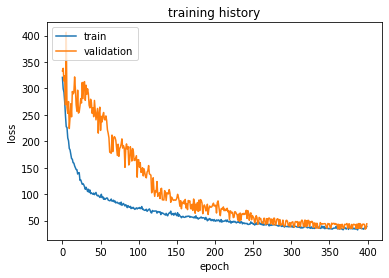

In [12]:
# train
history = model.fit(
    batch_size=16,
    validation_batch_size=4,
    callbacks=callbacks,
    epochs=400,
    n_workers=8,
    steps_per_epoch=None,
)

# plot training
ax = plt.axes(title='training history', xlabel='epoch', ylabel='loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left');